# Age discrepancy

Now we will try to correlate age discrepancy with some scores of the behavioral dataset. Our model to predict age uses only the structural MRI features.
Thing I would like to check: MULTIPLE TESTING/INBALANCE PROBLEMS?

In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, cv_for_cde, create_dataset_eeg
from cde.density_estimator import MixtureDensityNetwork
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.python.keras.activations import tanh
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Behavioral data
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
# Create dataset MRI
target = 'Age'
data = create_dataset_mri(SCORE = target)
autistics = create_dataset_mri(select_disease = 'Autism Spectrum Disorder', select_category = 'DX_01', SCORE = target)
combined = create_dataset_mri(select_disease = 'ADHD-Combined Type', select_category = 'DX_01', SCORE = target)
inattentive = create_dataset_mri(select_disease = 'ADHD-Inattentive Type', select_category = 'DX_01', SCORE = target)

In [3]:
data = data.loc[~data['ID'].isin(list(set(autistics['ID']).union(set(combined['ID'])).union(set(inattentive['ID']))))]
#data = data.loc[data['DX_01'].isin(['No Diagnosis Given'])]
data.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)

In [4]:
# labels and features
y = data[target]
X = data.drop([target], axis=1)
X = np.array(X)
y = np.array(y)

# autistics
autistics = np.array(autistics)
ID_autistics = autistics[:,0]
X_autistics = autistics[:,2:]
y_autistics = autistics[:, 1]
y_autistics = y_autistics.reshape((-1,1))
# combined
combined = np.array(combined)
ID_combined = combined[:,0]
X_combined = combined[:,2:]
y_combined = combined[:, 1]
y_combined = y_combined.reshape((-1,1))
#inattentive
inattentive = np.array(inattentive)
ID_inattentive = inattentive[:,0]
X_inattentive = inattentive[:,2:]
y_inattentive = inattentive[:, 1]
y_inattentive = y_inattentive.reshape((-1,1))
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
ID_train = X_train[:,0]
X_train = X_train[:,1:]
ID_test = X_test[:,0]
X_test = X_test[:,1:]
y_train = np.array(y_train, dtype=np.float64)
X_train = np.array(X_train, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64)
X_autistics = np.array(X_autistics, dtype=np.float64)
y_autistics = np.array(y_autistics, dtype=np.float64)
X_combined = np.array(X_combined, dtype=np.float64)
y_combined  = np.array(y_combined, dtype=np.float64)
X_inattentive = np.array(X_inattentive, dtype=np.float64)
y_inattentive = np.array(y_inattentive, dtype=np.float64)

In [5]:
# Now add again the patient with autism-combined-inattentive to the TEST set
ID_test = np.concatenate((ID_test, ID_autistics, ID_combined, ID_inattentive))
y_test = np.concatenate((y_test, y_autistics, y_combined, y_inattentive))
X_test = np.concatenate((X_test, X_autistics, X_combined, X_inattentive))

In [6]:
# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = MixtureDensityNetwork('MDN', ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.mean_(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))

1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 693.184
mean log-loss train: 1.4843
Test MSE: 5.181866149917488


In [7]:
# Define discrepancy
std = model.std_(X_test)
discrepancy = np.divide((y_test-y_pred), std)
#discrepancy = y_test-y_pred

In [8]:
discrepancy.shape

(679, 1)

In [9]:
# Get dataframe for test observations with behavioral data + discrepancy
data = {'discrepancy':discrepancy[:,0]}
discrepancy_df = pd.DataFrame(data)
ID_df = pd.DataFrame({'EID':ID_test})
discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)

In [10]:
# Get the correlations
correlations = dataframe[dataframe.columns[1:]].corr()['discrepancy'][:]
# Inspect correlations
correlations[correlations > 0.3]  

discrepancy        1.000000
Age                0.369374
DX_06_Confirmed    0.769753
ASR_Total          0.303549
CAARS_HR_Raw       0.452481
CAARS_ADHD_Raw     0.352107
CELF_SA_R          0.311133
CLEF5M_MI_Raw      0.304408
CLEF5M_CS_Raw      0.343292
CLEF5M_FL_Raw      0.521993
CLEF5M_TMI_Stnd    0.373414
EVT2_RawScore      0.336129
KBIT_NV_Raw        0.509033
KBIT_V_Raw         0.596097
Picture_Seq_Raw    0.377324
PPVT4_RawScore     0.439020
STAI_SA_T          0.403632
STAI_TA_T          0.301668
WAIS_DS_B_R        0.322735
WAIS_DS_Total_R    0.368377
Name: discrepancy, dtype: float64

In [11]:
# Frequencies of major disturb in behavioral dataset
dataframe['DX_01'].value_counts()

ADHD-Combined Type                                                     217
ADHD-Inattentive Type                                                  188
Autism Spectrum Disorder                                                73
No Diagnosis Given                                                      53
Major Depressive Disorder                                               18
Specific Learning Disorder with Impairment in Reading                   18
No Diagnosis Given: Incomplete Eval                                     16
Generalized Anxiety Disorder                                            15
Social Anxiety (Social Phobia)                                          13
Other Specified Anxiety Disorder                                         8
Other Specified Attention-Deficit/Hyperactivity Disorder                 8
Intellectual Disability-Mild                                             7
ADHD-Hyperactive/Impulsive Type                                          6
Separation Anxiety       

## Consider the most frequent situations: ADHD Inattentive, ADHD Combined, Autism, Healthy. Specific impairment in Reading

In [12]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder'])]
# Correct for inbalance
df1 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type'])]
df2 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Inattentive Type'])]
df3 = dataframe.loc[dataframe['DX_01'].isin(['No Diagnosis Given'])]
df4 = dataframe.loc[dataframe['DX_01'].isin(['Autism Spectrum Disorder'])]
size = min(df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0])#, df5.shape[0])
df1 = df1.head(size)
df2 = df2.head(size)
df3 = df3.head(size)
df4 = df4.head(size)
df = df1.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)
df = df.append(df4, ignore_index=True)


## t-test Healthy vs ADHD Inattentive

In [13]:
adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
no_adhd = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
from scipy.stats import ttest_ind
res = ttest_ind(np.array(adhd), np.array(no_adhd), equal_var=False)
res

Ttest_indResult(statistic=0.2832262298846038, pvalue=0.7775809144068493)

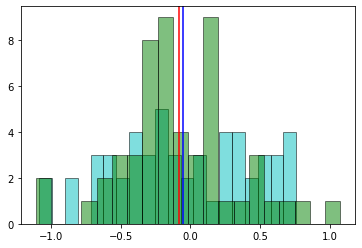

In [14]:
import matplotlib.pyplot as plt
plt.hist(adhd[:80], bins=20, color='c', edgecolor='k', alpha=0.5)     # take same number of obs as no_adhd
plt.hist(no_adhd, bins=20, color='g', edgecolor='k', alpha=0.5)
plt.axvline(x=np.mean(adhd), color = 'b')
plt.axvline(x=np.mean(no_adhd), color = 'r')

## t-test Healthy vs Autism

In [15]:
autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
from scipy.stats import ttest_ind
res = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)
res

Ttest_indResult(statistic=3.176953437522702, pvalue=0.0019967494361041636)

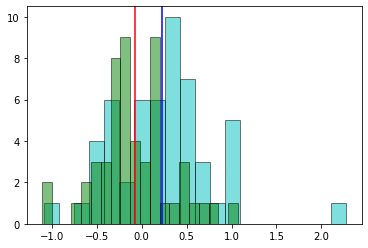

In [16]:
import matplotlib.pyplot as plt
plt.hist(autism, bins=20, color='c', edgecolor='k', alpha=0.5)     # take same number of obs as no_adhd
plt.hist(healthy, bins=20, color='g', edgecolor='k', alpha=0.5)
plt.axvline(x=np.mean(autism), color = 'b')
plt.axvline(x=np.mean(healthy), color = 'r')

# ANOVA

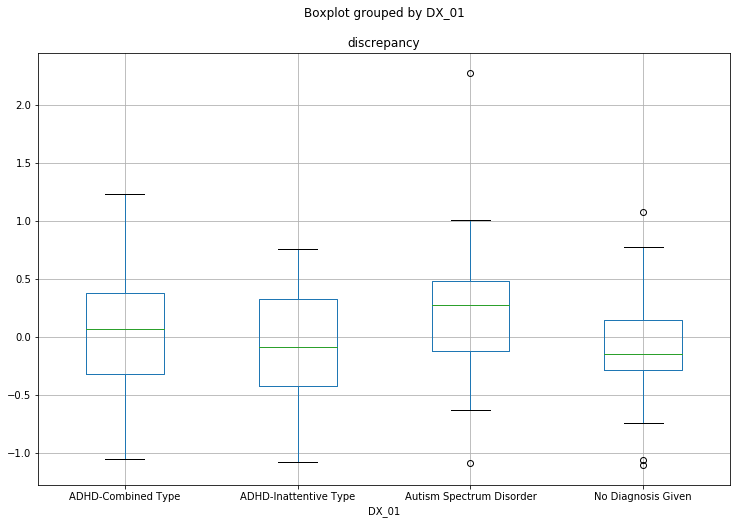

In [17]:
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

In [18]:
model = ols('discrepancy ~ DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)
model.summary()

             sum_sq     df         F    PR(>F)
DX_01      3.052472    3.0  4.091317  0.007543
Residual  51.728592  208.0       NaN       NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     4.091
Date:                Wed, 04 Dec 2019   Prob (F-statistic):            0.00754
Time:                        22:22:06   Log-Likelihood:                -151.29
No. Observations:                 212   AIC:                             310.6
Df Residuals:                     208   BIC:                             324.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.0658      0.069      0.961      0.338      -0.069       0.201
DX_01[T.ADHD-Inattentive Type]       -0.1191      0.097     -1.229      0.220      -0.310       0.072
DX_01[T.Autism Spectrum Disorder]     0.1591      0.097      1.642      0.102      -0.032       0.350
DX_01[T.No Diagnosis Given]          -0.1443      0.097     -1.490      0.138      -0.335       0.047
==============================================================================
Omnibus:                        7.123   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                8.213
Skew:                           0.286   Prob(JB):                       0.0165
Kurtosis:                       3.777   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We got a significant F-test and significant pval for autism.

## Evaluate these quantities as an average over differen splits

In [19]:
def t_test(repetitions, correct_imbalance = True, multiple_testing_correction = 'fdr_bh'):
    # Behavioral data
    behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
    # Create dataset MRI
    target = 'Age'
    data = create_dataset_mri(SCORE = target)
    autistics = create_dataset_mri(select_disease = 'Autism Spectrum Disorder', select_category = 'DX_01', SCORE = target)
    combined = create_dataset_mri(select_disease = 'ADHD-Combined Type', select_category = 'DX_01', SCORE = target)
    inattentive = create_dataset_mri(select_disease = 'ADHD-Inattentive Type', select_category = 'DX_01', SCORE = target)
    data = data.loc[~data['ID'].isin(list(set(autistics['ID']).union(set(combined['ID'])).union(set(inattentive['ID']))))]
    data.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    # labels and features
    y = data[target]
    X = data.drop([target], axis=1)
    X = np.array(X)
    y = np.array(y)

    # autistics
    autistics = np.array(autistics)
    ID_autistics = autistics[:,0]
    X_autistics = autistics[:,2:]
    y_autistics = autistics[:, 1]
    y_autistics = y_autistics.reshape((-1,1))
    X_autistics = np.array(X_autistics, dtype=np.float64)
    y_autistics = np.array(y_autistics, dtype=np.float64)
    
    # combined
    combined = np.array(combined)
    ID_combined = combined[:,0]
    X_combined = combined[:,2:]
    y_combined = combined[:, 1]
    y_combined = y_combined.reshape((-1,1))
    X_combined = np.array(X_combined, dtype=np.float64)
    y_combined  = np.array(y_combined, dtype=np.float64)
    
    #inattentive
    inattentive = np.array(inattentive)
    ID_inattentive = inattentive[:,0]
    X_inattentive = inattentive[:,2:]
    y_inattentive = inattentive[:, 1]
    y_inattentive = y_inattentive.reshape((-1,1))
    X_inattentive = np.array(X_inattentive, dtype=np.float64)
    y_inattentive = np.array(y_inattentive, dtype=np.float64)
    
    # things I want to compute
    t_adhd = []
    t_adhd_combined = []
    t_autism = []
    
    for i in range(repetitions):
        # split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        y_train = y_train.reshape((-1,1))
        y_test = y_test.reshape((-1,1))
        ID_train = X_train[:,0]
        X_train = X_train[:,1:]
        ID_test = X_test[:,0]
        X_test = X_test[:,1:]
        y_train = np.array(y_train, dtype=np.float64)
        X_train = np.array(X_train, dtype=np.float64)
        y_test = np.array(y_test, dtype=np.float64)
        X_test = np.array(X_test, dtype=np.float64)

        # Now add again the patient with autism-combined-inattentive to the TEST set
        ID_test = np.concatenate((ID_test, ID_autistics, ID_combined, ID_inattentive))
        y_test = np.concatenate((y_test, y_autistics, y_combined, y_inattentive))
        X_test = np.concatenate((X_test, X_autistics, X_combined, X_inattentive))
    
        # Set model parameters
        ndim_x=X_train.shape[1]
        ndim_y=y_train.shape[1]
        # We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
        n = X_train.shape[0]
        d = X_train.shape[1]+y_train.shape[1]
        h = n**(-1/(d+1))
        model = MixtureDensityNetwork('{}'.format(i), ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
        # Fit
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.mean_(X_test)
        y_pred = y_pred.reshape((-1,1))
        # Define discrepancy
        std = model.std_(X_test)
        discrepancy = np.divide((y_test-y_pred), std)
        # Get dataframe for test observations with behavioral data + discrepancy
        data = {'discrepancy':discrepancy[:,0]}
        discrepancy_df = pd.DataFrame(data)
        ID_df = pd.DataFrame({'EID':ID_test})
        discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
        dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
        dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)
        # Select most frequent diseases
        df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder'])]
        if correct_imbalance == True:
            # Correct for inbalance
            df1 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type'])]
            df2 = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Inattentive Type'])]
            df3 = dataframe.loc[dataframe['DX_01'].isin(['No Diagnosis Given'])]
            df4 = dataframe.loc[dataframe['DX_01'].isin(['Autism Spectrum Disorder'])]
            size = min(df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0])
            df1 = df1.head(size)
            df2 = df2.head(size)
            df3 = df3.head(size)
            df4 = df4.head(size)
            df = df1.append(df2, ignore_index=True)
            df = df.append(df3, ignore_index=True)
            df = df.append(df4, ignore_index=True)

        
        # t-test for autism vs healthy
        autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res1 = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)
        
        
        # t-test for inattentive vs healthy
        adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
        no_adhd = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res2 = ttest_ind(np.array(adhd), np.array(no_adhd), equal_var=False)
        
        
        # t-test for combined vs healthy
        combined = df[df['DX_01'] == 'ADHD-Combined Type']['discrepancy']
        no_combined = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res3 = ttest_ind(np.array(combined), np.array(no_combined), equal_var=False)
        
        
        # Correct p-values for multiple-testing
        p_vals = [res1[1], res2[1], res3[1]]
        corrected = multipletests(pvals = p_vals, alpha=0.05, method = multiple_testing_correction)
        t_autism.append(corrected[1][0])
        t_adhd.append(corrected[1][1])
        t_adhd_combined.append(corrected[1][2])
        
    print('Mean t-test p-val (inattentive vs healthy): {} \n Mean t-test p-val (combined vs healthy): {} \n Mean t-test p-val (autism vs healthy): {}'.format(np.mean(t_adhd), np.mean(t_adhd_combined), np.mean(t_autism)))

In [20]:
t_test(10)

1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 689.001
mean log-loss train: 1.4754
1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 682.280
mean log-loss train: 1.4610
1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | loss: 657.662
mean log-loss train: 1.4083
1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 663.465
mean log-loss train: 1.4207
1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | loss: 676.130
mean log-loss train: 1.4478
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | loss: 705.456
mean log-loss train: 1.5106
1000/1000 [100%] ██████████████████████████████ Elapsed: 15s | loss: 664.106
mean log-loss train: 1.4221
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | loss: 671.066
mean log-loss train: 1.4370
1000/1000 [100%] ██████████████████████████████ Elapsed: 15s | loss: 702.781
mean log-loss train: 1.5049
1000/1000 [100%] ██████████████████████████████ Elapsed

Using the Benjamini-Hochberg correction there is (some) evidence for autism in the t-tests!

# What if we control for Age?

In [23]:
df['Age'] = np.floor(df['Age'])
#df = df.loc[df['Age'] 15]      # AGE INTERVAL

model = ols('discrepancy ~ Age + DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df          F        PR(>F)
DX_01      2.717668    3.0   3.701932  1.265856e-02
Age       10.107275    1.0  41.303548  9.435006e-10
Residual  48.696732  199.0        NaN           NaN


In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     15.54
Date:                Wed, 20 Nov 2019   Prob (F-statistic):           4.43e-11
Time:                        11:13:01   Log-Likelihood:                -143.35
No. Observations:                 204   AIC:                             296.7
Df Residuals:                     199   BIC:                             313.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.5716      0.112     -5.087      0.000      -0.793      -0.350
DX_01[T.ADHD-Inattentive Type]        0.0088      0.100      0.088      0.930      -0.188       0.205
DX_01[T.Autism Spectrum Disorder]     0.1698      0.100      1.691      0.092      -0.028       0.368
DX_01[T.No Diagnosis Given]          -0.1604      0.098     -1.633      0.104      -0.354       0.033
Age                                   0.0649      0.010      6.427      0.000       0.045       0.085
==============================================================================
Omnibus:                       13.747   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.565
Skew:                          -0.432   Prob(JB):                     5.64e-05
Kurtosis:                       4.246   Cond. No.                         46.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

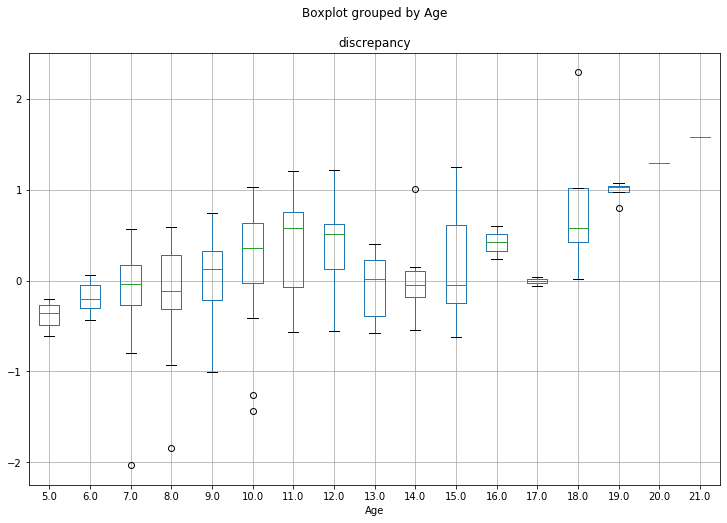

In [25]:
#Create a boxplot
df.boxplot('discrepancy', by='Age', figsize=(12, 8))

In [26]:
model = ols('Age ~ DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)
model.summary()

               sum_sq     df         F    PR(>F)
DX_01      156.882353    3.0  4.353078  0.005377
Residual  2402.627451  200.0       NaN       NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.353
Date:                Wed, 20 Nov 2019   Prob (F-statistic):            0.00538
Time:                        11:13:18   Log-Likelihood:                -541.02
No. Observations:                 204   AIC:                             1090.
Df Residuals:                     200   BIC:                             1103.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             8.7647      0.485     18.059      0.000       7.808       9.722
DX_01[T.ADHD-Inattentive Type]        1.8627      0.686      2.714      0.007       0.509       3.216
DX_01[T.Autism Spectrum Disorder]     2.1765      0.686      3.171      0.002       0.823       3.530
DX_01[T.No Diagnosis Given]           0.7059      0.686      1.028      0.305      -0.648       2.059
==============================================================================
Omnibus:                       18.905   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.549
Skew:                           0.786   Prob(JB):                     2.09e-05
Kurtosis:                       3.248   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
model = ols('discrepancy ~ Age',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)
model.summary()

             sum_sq     df         F        PR(>F)
Age       12.492536    1.0  49.08143  3.581192e-11
Residual  51.414400  202.0       NaN           NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     49.08
Date:                Wed, 20 Nov 2019   Prob (F-statistic):           3.58e-11
Time:                        11:13:23   Log-Likelihood:                -148.89
No. Observations:                 204   AIC:                             301.8
Df Residuals:                     202   BIC:                             308.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6168      0.105     -5.856      0.000      -0.825      -0.409
Age            0.0699      0.010      7.006      0.000       0.050       0.090
==============================================================================
Omnibus:                       16.838   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.790
Skew:                          -0.492   Prob(JB):                     2.51e-06
Kurtosis:                       4.437   Cond. No.                         31.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Boxplot for children aged <17:

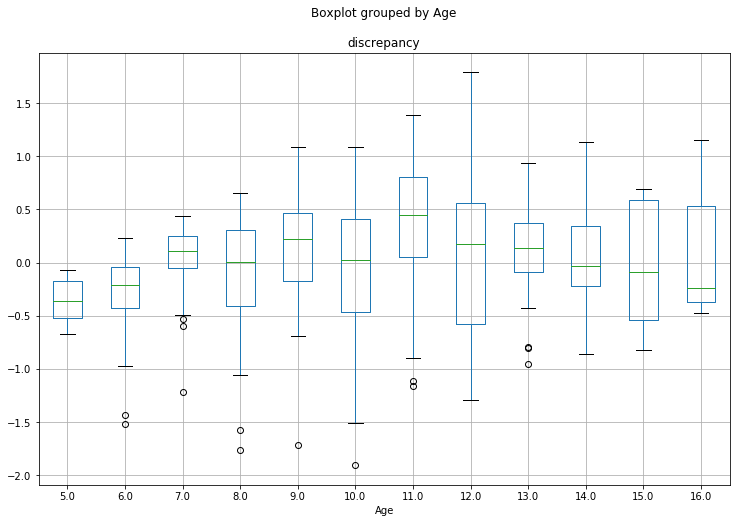

In [41]:
df['Age'] = np.floor(dataframe['Age'])
df = df.loc[df['Age']<17]
#Create a boxplot
df.boxplot('discrepancy', by='Age', figsize=(12, 8))

## Comments
Including age makes the p-val for autism less significant, but this makes sence since age is quite correlated with discrepancy of age itself (and with the diseases!)